In [465]:
import ops
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape, Bidirectional, RNN, SimpleRNN, AveragePooling2D
from keras.utils import to_categorical

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
(2115, 22, 1000)
(2115, 1000)


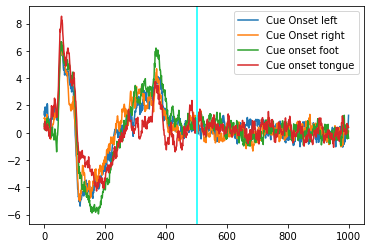

In [466]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]
print(X_train_valid.shape)
print(ch_data.shape)

class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [467]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [468]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (1000, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460, 400, 1, 22)
Shape of validation set after dimension reshaping: (1000, 400, 1, 22)

In [359]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(Bidirectional(LSTM(14, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False)))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 134, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_28 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_28 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 45, 1, 50)        

In [469]:
# Model parameters
learning_rate = 1e-4
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [361]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
117/117 [==============================] - 44s 300ms/step - loss: 1.3938 - accuracy: 0.2489 - val_loss: 1.3851 - val_accuracy: 0.2540
Epoch 2/100
117/117 [==============================] - 33s 283ms/step - loss: 1.3881 - accuracy: 0.2582 - val_loss: 1.3817 - val_accuracy: 0.2710
Epoch 3/100
117/117 [==============================] - 34s 291ms/step - loss: 1.3838 - accuracy: 0.2802 - val_loss: 1.3775 - val_accuracy: 0.2930
Epoch 4/100
117/117 [==============================] - 38s 323ms/step - loss: 1.3829 - accuracy: 0.2728 - val_loss: 1.3732 - val_accuracy: 0.3180
Epoch 5/100
117/117 [==============================] - 33s 285ms/step - loss: 1.3787 - accuracy: 0.2924 - val_loss: 1.3664 - val_accuracy: 0.3260
Epoch 6/100
117/117 [==============================] - 33s 279ms/step - loss: 1.3698 - accuracy: 0.3139 - val_loss: 1.3552 - val_accuracy: 0.3500
Epoch 7/100
117/117 [==============================] - 32s 277ms/step - loss: 1.3611 - accuracy: 0.3279 - val_loss: 1.3427 -

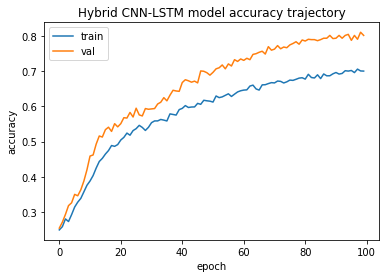

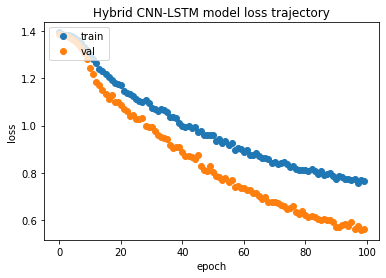

In [364]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [366]:
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM with BiDirection model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM with BiDirection model: 0.7020316123962402


In [559]:
#Base CNN model
cnn_model = Sequential()
# Conv. block 1
cnn_model.add(Conv2D(filters=25, kernel_size=(1,1), padding='same', activation='relu', input_shape=(400,1,22)))
cnn_model.add(AveragePooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 2
cnn_model.add(Conv2D(filters=50, kernel_size=(6,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=50, kernel_size=(6,1), padding='same', activation='relu'))
cnn_model.add(AveragePooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 3
cnn_model.add(Conv2D(filters=100, kernel_size=(6,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=100, kernel_size=(6,1), padding='same', activation='relu'))
cnn_model.add(AveragePooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 4
cnn_model.add(Conv2D(filters=200, kernel_size=(6,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=200, kernel_size=(6,1), padding='same', activation='relu'))
cnn_model.add(AveragePooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# FC
cnn_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
cnn_model.add(Dense(22, activation='relu'))

# Output layer with Softmax activation 
cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_model.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 400, 1, 25)        575       
                                                                 
 average_pooling2d_52 (Aver  (None, 134, 1, 25)        0         
 agePooling2D)                                                   
                                                                 
 batch_normalization_112 (B  (None, 134, 1, 25)        100       
 atchNormalization)                                              
                                                                 
 dropout_87 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_163 (Conv2D)         (None, 134, 1, 50)        7550      
                                                                 
 conv2d_164 (Conv2D)         (None, 134, 1, 50)      

In [560]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

cnn_optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_train,
             y_train,
             batch_size=96,
             epochs=100,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
78/78 [==============================] - 17s 174ms/step - loss: 1.4299 - accuracy: 0.2807 - val_loss: 1.4424 - val_accuracy: 0.2670
Epoch 2/100
78/78 [==============================] - 13s 172ms/step - loss: 1.3559 - accuracy: 0.3189 - val_loss: 1.3061 - val_accuracy: 0.3860
Epoch 3/100
78/78 [==============================] - 13s 170ms/step - loss: 1.2901 - accuracy: 0.3877 - val_loss: 1.2536 - val_accuracy: 0.4360
Epoch 4/100
78/78 [==============================] - 13s 171ms/step - loss: 1.2402 - accuracy: 0.4290 - val_loss: 1.2512 - val_accuracy: 0.4630
Epoch 5/100
78/78 [==============================] - 14s 179ms/step - loss: 1.2290 - accuracy: 0.4340 - val_loss: 1.1520 - val_accuracy: 0.4740
Epoch 6/100
78/78 [==============================] - 13s 172ms/step - loss: 1.2086 - accuracy: 0.4473 - val_loss: 1.1543 - val_accuracy: 0.4660
Epoch 7/100
78/78 [==============================] - 14s 175ms/step - loss: 1.1921 - accuracy: 0.4564 - val_loss: 1.1264 - val_accuracy:

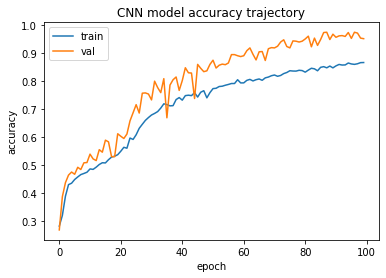

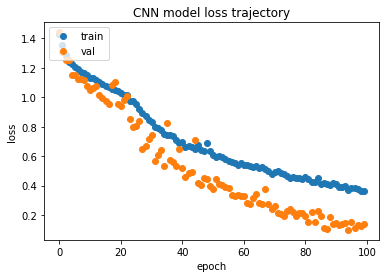

In [561]:
# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [562]:
cnn_score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN model:',cnn_score[1])

Test accuracy of the CNN model: 0.6478555202484131


In [452]:
#Base CNN + RNN model
cnn_rnn_model = Sequential()

# Conv. block 1
cnn_rnn_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='relu', input_shape=(400,1,22)))
cnn_rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
cnn_rnn_model.add(BatchNormalization())
cnn_rnn_model.add(Dropout(0.6))

# Conv. block 2
cnn_rnn_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='relu'))
cnn_rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_rnn_model.add(BatchNormalization())
cnn_rnn_model.add(Dropout(0.6))

# Conv. block 3
cnn_rnn_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='relu'))
cnn_rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_rnn_model.add(BatchNormalization())
cnn_rnn_model.add(Dropout(0.6))

# Conv. block 4
cnn_rnn_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='relu'))
cnn_rnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_rnn_model.add(BatchNormalization())
cnn_rnn_model.add(Dropout(0.6))

#CNN+RNN layer
cnn_rnn_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
cnn_rnn_model.add(Dense((40))) # FC layer with 100 units
cnn_rnn_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
cnn_rnn_model.add(SimpleRNN(22, input_shape=(40,1), return_sequences=True))
cnn_rnn_model.add(SimpleRNN(22, return_sequences=True))
cnn_rnn_model.add(SimpleRNN(22, return_sequences=False))
cnn_rnn_model.add(Dense(4))
cnn_rnn_model.build()

# Output layer with Softmax activation 
cnn_rnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
cnn_rnn_model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 134, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_79 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_51 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 45, 1, 50)       

In [453]:
cnn_rnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Compiling the model
cnn_rnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_rnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_rnn_model_results = cnn_rnn_model.fit(x_train,
             y_train,
             batch_size=32,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
234/234 [==============================] - 53s 162ms/step - loss: 1.4390 - accuracy: 0.2524 - val_loss: 1.3987 - val_accuracy: 0.2680
Epoch 2/100
234/234 [==============================] - 39s 165ms/step - loss: 1.4032 - accuracy: 0.2646 - val_loss: 1.3927 - val_accuracy: 0.2520
Epoch 3/100
234/234 [==============================] - 38s 161ms/step - loss: 1.3905 - accuracy: 0.2693 - val_loss: 1.3890 - val_accuracy: 0.2360
Epoch 4/100
234/234 [==============================] - 38s 162ms/step - loss: 1.3847 - accuracy: 0.2815 - val_loss: 1.3850 - val_accuracy: 0.2520
Epoch 5/100
234/234 [==============================] - 38s 161ms/step - loss: 1.3883 - accuracy: 0.2736 - val_loss: 1.3953 - val_accuracy: 0.2390
Epoch 6/100
234/234 [==============================] - 38s 161ms/step - loss: 1.3809 - accuracy: 0.2850 - val_loss: 1.3764 - val_accuracy: 0.2610
Epoch 7/100
234/234 [==============================] - 38s 162ms/step - loss: 1.3724 - accuracy: 0.2972 - val_loss: 1.3705 -

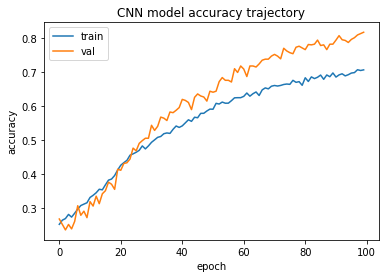

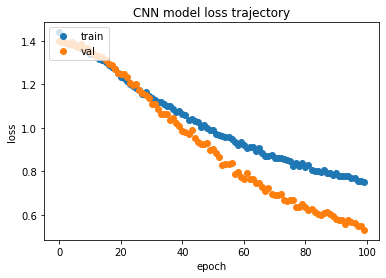

In [454]:
# Plotting accuracy trajectory
plt.plot(cnn_rnn_model_results.history['accuracy'])
plt.plot(cnn_rnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_rnn_model_results.history['loss'],'o')
plt.plot(cnn_rnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [455]:
cnn_rnn_score = cnn_rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN-RNN model:',cnn_rnn_score[1])

Test accuracy of the CNN-RNN model: 0.6659142374992371
